In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

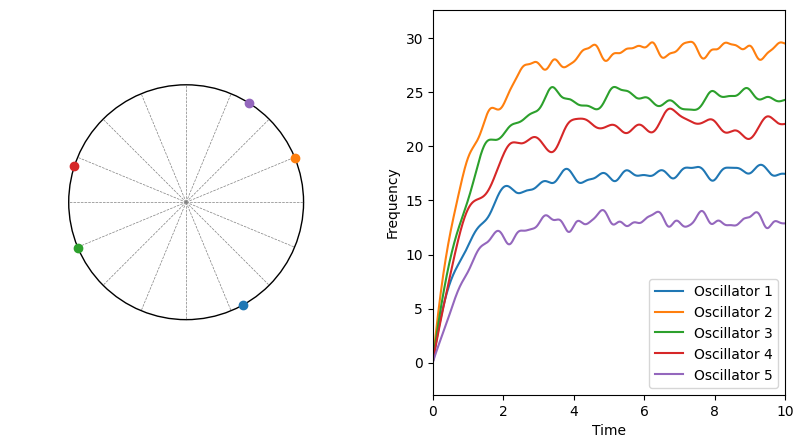

In [3]:
# System parameters
N = 5  # Number of oscillators
timesteps = 1000  # Number of timesteps
dt = 0.01  # Time step size

# Parameters (uniform values for m and d, but P is nonuniform)
m = 0.5  # Inertia
d = 0.5  # Damping coefficient

# Create a complete graph adjacency matrix
A = np.ones((N, N)) - np.eye(N)

# Generate nonuniform power injections P
# Ensure |P_i - P_j| is large for connected pairs
np.random.seed(42)
P = np.random.uniform(5, 15, N)

# Initial conditions
theta = np.random.uniform(-np.pi, np.pi, N)
omega = np.zeros(N)

# Store trajectories for animation
theta_trajectory = []
omega_trajectory = []

for t in range(timesteps):
    theta_trajectory.append(theta.copy())
    omega_trajectory.append(omega.copy())
    
    # Compute the coupling term
    coupling = np.sum(A * np.sin(theta[:, None] - theta), axis=1)

    # Update angular velocities and positions
    omega_dot = (P - d * omega + coupling) / m
    omega += omega_dot * dt
    theta += omega * dt

# Convert trajectory to numpy array for easier indexing
theta_trajectory = np.array(theta_trajectory)
omega_trajectory = np.array(omega_trajectory)

# Normalize angles to [-pi, pi]
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

theta_trajectory = normalize_angle(theta_trajectory)

# Initialize the figure and axes
fig, (ax_circle, ax_freq) = plt.subplots(1, 2, figsize=(10, 5))
ax_circle.set_xlim(-1.5, 1.5)
ax_circle.set_ylim(-1.5, 1.5)
ax_circle.set_aspect("equal")
ax_circle.axis('off')

# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='-')
ax_circle.add_artist(circle)

# Number of radial gridlines
num_radial_lines = 16

# Add radial gridlines
angles = np.linspace(0, 2 * np.pi, num_radial_lines, endpoint=False)
for angle in angles:
    x = [0, np.cos(angle)]  # From origin to circumference
    y = [0, np.sin(angle)]
    ax_circle.plot(x, y, color='gray', linestyle='--', linewidth=0.5)  # Dashed gridline

# Initialize the oscillators (points on the circle)
oscillators = [ax_circle.plot([], [], "o")[0] for _ in range(N)]

# Compute the range of frequencies with a buffer
freq_min = np.min(omega_trajectory)
freq_max = np.max(omega_trajectory)
buffer = 0.1 * (freq_max - freq_min)  # 10% buffer

# Set up the frequency plot
ax_freq.set_xlim(0, timesteps * dt)
ax_freq.set_ylim(freq_min - buffer, freq_max + buffer)
ax_freq.set_xlabel("Time")
ax_freq.set_ylabel("Frequency")
frequency_lines = [ax_freq.plot([], [], label=f'Oscillator {i+1}')[0] for i in range(N)]
ax_freq.legend(loc="lower right")

# Animation of oscillators

def init():
    for osc in oscillators:
        osc.set_data([], [])
    for line in frequency_lines:
        line.set_data([], [])
    return oscillators + frequency_lines


def update(frame):
    # Update circle plot
    for i, osc in enumerate(oscillators):
        x = np.cos(theta_trajectory[frame, i])
        y = np.sin(theta_trajectory[frame, i])
        osc.set_data([x], [y])
    
    # Update frequency plot
    time = np.linspace(0, frame * dt, frame)
    for i, line in enumerate(frequency_lines):
        line.set_data(time, omega_trajectory[:frame, i])
    return oscillators + frequency_lines

ani = FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=True)
ani.save('nonuniform_oscillators.mp4', writer='ffmpeg', fps=30)
plt.show()
